In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sts
import gzip as gz
import pysam
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy
import glob
from joblib import Parallel, delayed
import sys
import argparse
import plotly.express as px
import plotly.io as pio
import os
from Bio.Seq import Seq
from Bio import SeqIO
import swifter
import sys
import plotly.express as px
from Levenshtein import distance
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import warnings
warnings.filterwarnings("ignore")

In [15]:
df = pd.read_csv("shuttlecock_positions/TC_00001.shuttlecock_pos.csv")

In [16]:
df.head()

frame     x    y      prob
0      0  1180  298  0.432867
1      0   448  474  0.411632
2      1  1183  298  0.547050
3      1   447  474  0.415733
4      2  1187  298  0.460242

In [17]:
df = df.merge(df.groupby(['x','y']).size().reset_index(),left_on=["x","y"],right_on=["x","y"],how="left")

In [18]:
df

frame     x    y      prob  0
0          0  1180  298  0.432867  1
1          0   448  474  0.411632  5
2          1  1183  298  0.547050  1
3          1   447  474  0.415733  4
4          2  1187  298  0.460242  2
...      ...   ...  ...       ... ..
94969  35052   334  216  0.349113  1
94970  35054   325  244  0.345318  1
94971  35054   314  154  0.223971  1
94972  35055   322  256  0.392399  1
94973  35056   305  188  0.260528  1

[94974 rows x 5 columns]

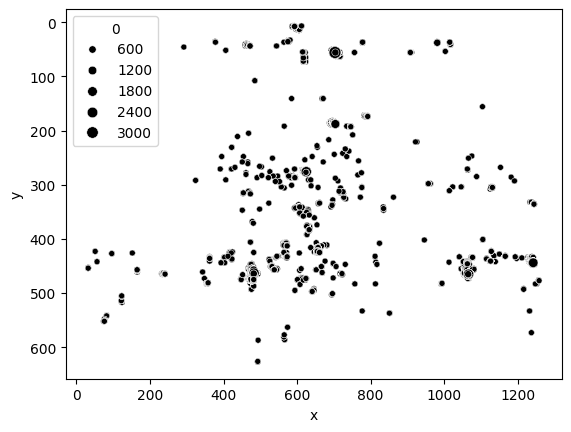

In [28]:
sns.scatterplot(data=df[df[0]>2],x='x',y='y',size=0,color="black")
plt.gca().invert_yaxis()

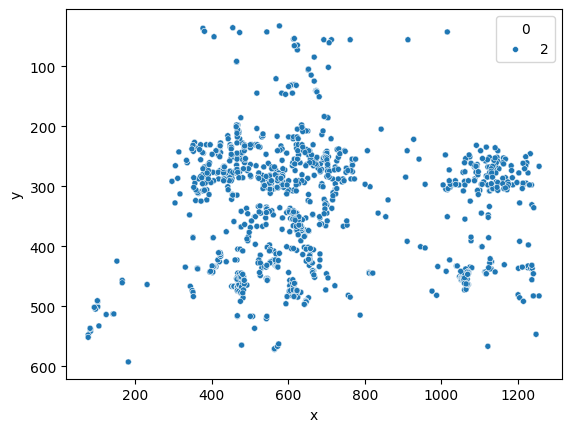

In [29]:
sns.scatterplot(data=df[df[0]==2],x='x',y='y',size=0)
plt.gca().invert_yaxis()

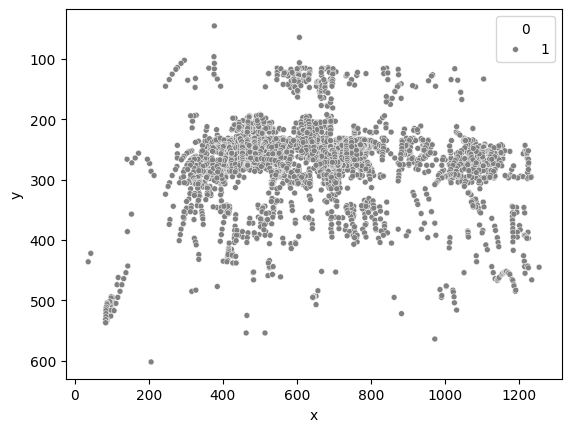

In [33]:
sns.scatterplot(data=df[(df[0]==1)&(df['prob']>0.6)],x='x',y='y',size=0,color="grey")
plt.gca().invert_yaxis()

<AxesSubplot:>

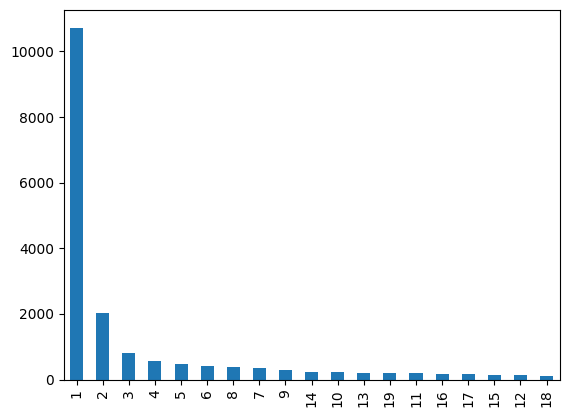

In [47]:
df[df[0]<20][0].value_counts().plot(kind='bar')

# looks like 2 is a good cutoff

In [22]:
df[df[0]==2]

frame     x    y      prob  0
4          2  1187  298  0.460242  2
52        29   452  467  0.396106  2
53        30   452  467  0.385748  2
54        30  1202  437  0.215804  2
56        31  1202  437  0.253486  2
...      ...   ...  ...       ... ..
94733  34919  1134  285  0.417385  2
94744  34922   483  473  0.442336  2
94754  34926   481  478  0.379049  2
94829  34962   942  255  0.480332  2
94931  35012  1062  355  0.229512  2

[2024 rows x 5 columns]

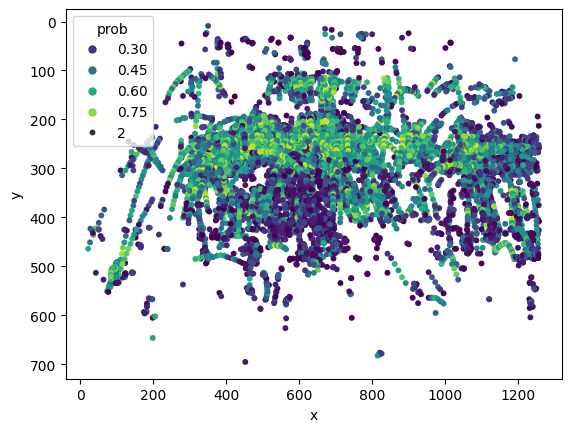

In [56]:
sns.scatterplot(data=df[df[0]<=2],x='x',y='y',hue="prob",palette="viridis",linewidth=0,size=2)
plt.gca().invert_yaxis()

# other people are playing at x=200 and x=1000, can we use clustering to find out?

In [57]:
df = df[df[0]<=2]

In [58]:
df.shape

(12752, 5)

In [59]:
df.head()

frame     x    y      prob  0
0      0  1180  298  0.432867  1
2      1  1183  298  0.547050  1
4      2  1187  298  0.460242  2
6      3  1191  298  0.429008  1
8      4   447  475  0.395821  1

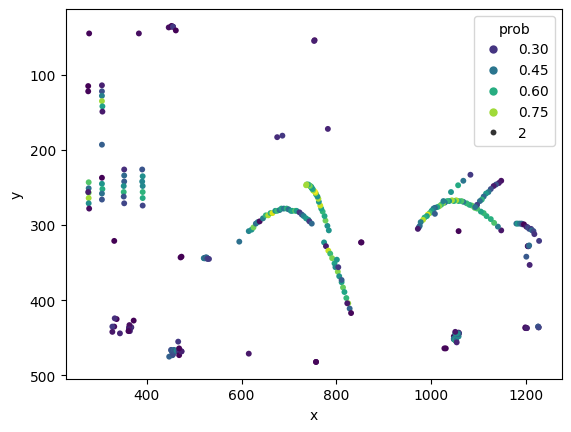

In [60]:
sns.scatterplot(data=df[df['frame']<=1000],x='x',y='y',hue="prob",palette="viridis",linewidth=0,size=2)
plt.gca().invert_yaxis()

In [61]:
start = 13*60
df = df[df.frame>start]

# every captured shuttlecock

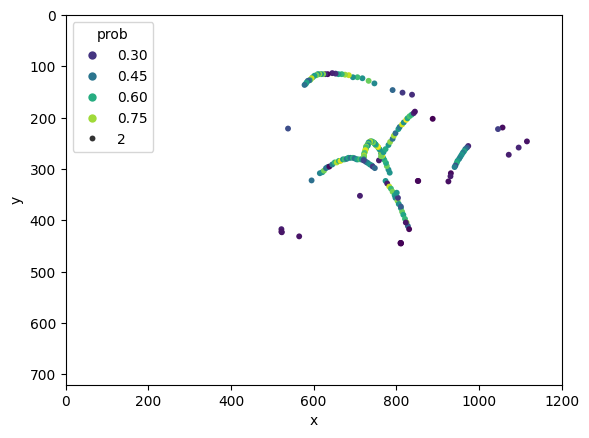

In [70]:
n=6
fps=60
sns.scatterplot(data=df[df['frame'].between(start,start+n*fps)],x='x',y='y',hue="prob",palette="viridis",linewidth=0,size=2)
plt.xlim(0,1200)
plt.ylim(0,720)
plt.gca().invert_yaxis()

# cleaned

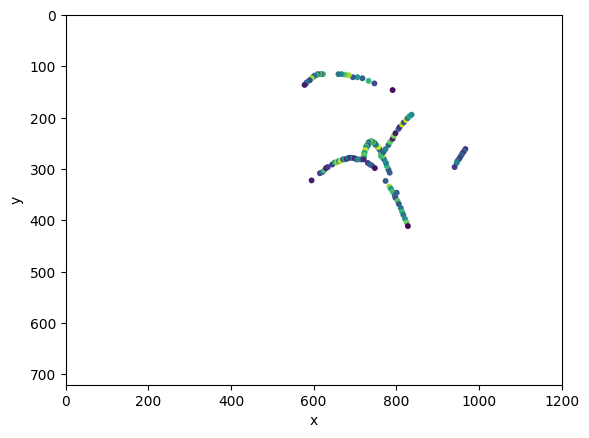

In [73]:
n=6
fps=60
sns.scatterplot(data=df[df['frame'].between(start,start+n*fps)&(df.prob>0.4)],x='x',y='y',hue="prob",palette="viridis",linewidth=0,size=2,legend=None)
plt.xlim(0,1200)
plt.ylim(0,720)
plt.gca().invert_yaxis()

# Good, we didn't miss any lines

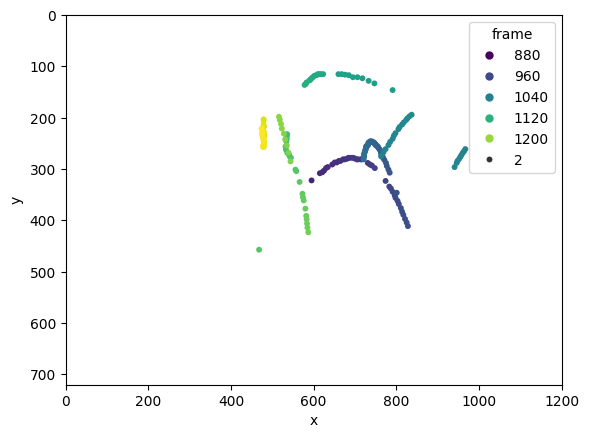

In [76]:
n=8
fps=60
sns.scatterplot(data=df[df['frame'].between(start,start+n*fps)&(df.prob>0.4)],x='x',y='y',hue="frame",palette="viridis",linewidth=0,size=2)
plt.xlim(0,1200)
plt.ylim(0,720)
plt.gca().invert_yaxis()

Text(0.5, 1.0, 'intermiate phase, between someone begin to serve')

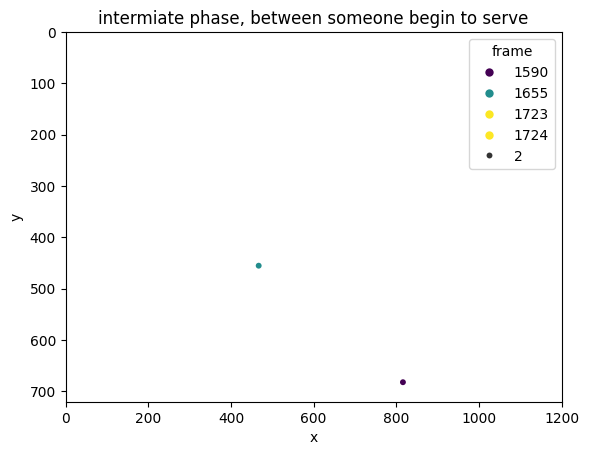

In [78]:

sns.scatterplot(data=df[df['frame'].between(26*fps,30*fps)&(df.prob>0.4)],x='x',y='y',hue="frame",palette="viridis",linewidth=0,size=2)
plt.xlim(0,1200)
plt.ylim(0,720)
plt.gca().invert_yaxis()
plt.title("intermiate phase, between someone begin to serve")

# curve estimation

In [80]:
df.frame.value_counts()

19831    4
23324    4
28183    4
23361    4
25683    3
        ..
12672    1
12673    1
12674    1
12675    1
35056    1
Name: frame, Length: 11403, dtype: int64

In [88]:
df = pd.read_csv("shuttlecock_positions/TC_00001.shuttlecock_pos.csv")
df = df.merge(df.groupby(['x','y']).size().reset_index(),left_on=["x","y"],right_on=["x","y"],how="left")
df = df[df[0]<=2]
start = 13*60
df = df[df.frame>start]
df = df[df['prob']>0.4]
df = df.sort_values("prob",ascending=False)
df = df.drop_duplicates("frame")
df['Visibility']=1
frame_list = df.frame.tolist()
for i in range(df.frame.min(),df.frame.max()+10):
    if not i in frame_list:
        df.loc[-1] = [i,0,0,0,0,0]
        df.index = df.index + 1
df = df.sort_values("frame")
# fill in mssing frame and use the box
df.head()

frame     x    y      prob  0  Visibility
28423    874  1226  435  0.402165  2           1
26713    875     0    0  0.000000  0           0
26712    876     0    0  0.000000  0           0
26711    877     0    0  0.000000  0           0
26710    878     0    0  0.000000  0           0

In [89]:
import pandas as pd
import numpy as np
import os
def smooth(df):
    #path = '41_predict.csv'
    # df = pd.read_csv(path)
    # df = df.fillna(0)

    x = df['x'].tolist()
    y = df['y'].tolist()
    vis = df['Visibility'].tolist()

    # Define distance
    pre_dif = []
    for i in range(0,len(x)):
        if i ==0:
            pre_dif.append(0)
        else:
            pre_dif.append(((x[i]-x[i-1])**2+(y[i]-y[i-1])**2)**(1/2)) 


    abnormal = [0]*len(pre_dif)
    X_abn = x
    y_abn = y
    dif_error = 2
    for i in range(len(pre_dif)):
        if i==len(pre_dif):
            abnormal[i]=0
        elif i==len(pre_dif)-1:
            abnormal[i]=0
        elif i==len(pre_dif)-2:
            abnormal[i]=0 
        elif i==len(pre_dif)-3:
            abnormal[i]=0
        elif pre_dif[i] >= 100 and pre_dif[i+1] >= 100:
            if vis[i:i+2] == [1,1]:# and series[i:i+2] == [1,1]:
                abnormal[i] ='bias1'
                X_abn[i] = 0
                y_abn[i] = 0
        elif pre_dif[i] >= 100 and pre_dif[i+2] >= 100:
            if pre_dif[i+1]<dif_error:
                if vis[i:i+3] == [1,1,1]:# and series[i:i+3] == [1,1,1]:
                    abnormal[i:i+2]=['bias2','bias2']
                    X_abn[i:i+2] = [0,0]
                    y_abn[i:i+2] = [0,0]
        elif pre_dif[i] >= 100 and pre_dif[i+3] >= 100:
            if pre_dif[i+1]<dif_error and pre_dif[i+2]<dif_error:
                if vis[i:i+4] == [1,1,1,1]:# and series[i:i+4] == [1,1,1,1]:
                    abnormal[i:i+3]=['bias3','bias3','bias3']
                    X_abn[i:i+3] = [0,0,0]
                    y_abn[i:i+3] = [0,0,0]
        elif pre_dif[i] >= 100 and pre_dif[i+4] >= 100:
            if pre_dif[i+1]<dif_error and pre_dif[i+2]<dif_error and pre_dif[i+3]<dif_error:
                if vis[i:i+5] == [1,1,1,1,1]:# and series[i:i+5] == [1,1,1,1,1]:
                    abnormal[i:i+4]=['bias4','bias4','bias4','bias4']
                    X_abn[i:i+4] = [0,0,0,0]
                    y_abn[i:i+4] = [0,0,0,0]


    # # II. Poly line check

    x_test = X_abn
    y_test = y_abn


    vis2 = [1] * len(df)
    for i in range(len(df)):
        if x_test[i] ==0 and y_test[i] ==0:
            vis2[i] = 0

    fuc2 = [0]*len(df)
    fuc1 = [0]*len(df)
    fuc0 = [0]*len(df)
    x_ck_bf = [0]*len(df)
    y_ck_bf = [0]*len(df)
    bf_dis = [0]*len(df)
    x_ck_af = [0]*len(df)
    y_ck_af = [0]*len(df)
    af_dis = [0]*len(df)

    for i in range(1,len(df)-7):
        if i==154:
            print(df.iloc[i:i+7])
            print(vis2[i:i+7])
            print('sum(vis2[i:i+7]) : {}'.format(sum(vis2[i:i+7])))
        if sum(vis2[i:i+7])>=2:
            vis_window = np.array(vis2[i:i+7])
            loc = np.where(vis_window==1)
            for k in loc:
                x_ar = np.array(x_test)[i+k]
                y_ar = np.array(y_test)[i+k]
            f1 = np.polyfit(x_ar, y_ar, 2)
            p1 = np.poly1d(f1)
            fuc2[i]=f1[0]
            fuc1[i]=f1[1]
            fuc0[i]=f1[2]
            
            if vis[i+7]==1:
                y_check_af=p1(x_test[i+7])
                x_ck_af[i+7]=x_test[i+7]
                y_ck_af[i+7]=y_check_af
                af_dis[i+7]=abs(y_check_af-y_test[i+7])
            elif vis[i+7]==0:
                x_ck_af[i+7]='NA'
                y_ck_af[i+7]='NA'
            if vis[i-1]==1:
                y_check_bf=p1(x_test[i-1])
                x_ck_bf[i-1]=x_test[i-1]
                y_ck_bf[i-1]=y_check_bf
                bf_dis[i-1]=abs(y_check_bf-y_test[i-1])
            elif vis[i-1]==0:
                x_ck_bf[i-1]='NA'
                y_ck_bf[i-1]='NA'



    # # III. 2nd Denoise

    x_test_2nd = X_abn
    y_test_2nd = y_abn
    abnormal2 = abnormal

    for i in range(len(df)):
        if af_dis[i]>30 and vis2[i]==1:
            if bf_dis[i]>30 and vis2[i]==1:
                x_test_2nd[i]=0
                y_test_2nd[i]=0
                abnormal2[i]='2bias1'
            elif bf_dis[i+1]>30 and vis2[i+1]==1:
                if af_dis[i+1]<30:
                    x_test_2nd[i:i+2]=[0,0]
                    y_test_2nd[i:i+2]=[0,0]
                    abnormal2[i:i+2]=['2bias2','2bias2']
            elif bf_dis[i+2]>30 and vis2[i+1:i+3]==[1,1]:
                if af_dis[i+1]<30 and af_dis[i+2]<30:
                    x_test_2nd[i:i+3]=[0,0,0]
                    y_test_2nd[i:i+3]=[0,0,0]
                    abnormal2[i:i+3]=['2bias3','2bias3','2bias3']
            elif bf_dis[i+3]>30 and vis2[i+1:i+4]==[1,1,1]:
                if af_dis[i+1]<30 and af_dis[i+2]<30 and af_dis[i+3]<30:
                    x_test_2nd[i:i+4]=[0,0,0,0]
                    y_test_2nd[i:i+4]=[0,0,0,0]
                    abnormal2[i:i+4]=['2bias4','2bias4','2bias4','2bias4']
        if i + 4 < len(df):
            if bf_dis[i+4]>30 and vis2[i+1:i+5]==[1,1,1,1]:
                if af_dis[i+1]<30 and af_dis[i+2]<30 and af_dis[i+3]<30 and af_dis[i+4]<30:
                    x_test_2nd[i:i+5]=[0,0,0,0,0]
                    y_test_2nd[i:i+5]=[0,0,0,0,0]
                    abnormal2[i:i+5]=['2bias5','2bias5','2bias5','2bias5','2bias5']
        if i + 5 < len(df):
            if bf_dis[i+5]>30 and vis2[i+1:i+6]==[1,1,1,1,1]:
                if af_dis[i+1]<30 and af_dis[i+2]<30 and af_dis[i+3]<30 and af_dis[i+4]<30 and af_dis[i+5]<30:
                    x_test_2nd[i:i+6]=[0,0,0,0,0,0]
                    y_test_2nd[i:i+6]=[0,0,0,0,0,0]
                    abnormal2[i:i+6]=['2bias6','2bias6','2bias6','2bias6','2bias6','2bias6']
                
        elif af_dis[i]>1000 and vis2[i]==1:
            x_test_2nd[i]=0
            y_test_2nd[i]=0
            abnormal2[i]='2bias1'
        
        elif bf_dis[i]>1000 and vis2[i]==1:
            x_test_2nd[i]=0
            y_test_2nd[i]=0
            abnormal2[i]='2bias1'


    # # IV. Compensate

    vis3 = [1] * len(df)
    for i in range(len(df)):
        if x_test_2nd[i] ==0 and y_test_2nd[i] ==0:
            # print('frame " {}'.format(i))
            vis3[i] = 0

    f2 = fuc2
    f1 = fuc1
    f0 = fuc0
    x_sm = x_test_2nd
    y_sm = y_test_2nd
    comp_ft = [0] * len(df)
    comp_bk = [0] * len(df)
    for i in range(len(vis3)):
        if af_dis[i]!=0 and bf_dis[i]!=0 and af_dis[i]<5 and bf_dis[i]<5:
            if sum(vis3[i-7:i])!=7: # front side compensate
                print(vis3[i-7:i])
                for k in range(5):
                    if vis3[i-7+k:i-4+k]==[1,0,1]:
                        x_ev = (x_sm[i-7+k]+x_sm[i-5+k])/2
                        y_ev = f2[i-7]*x_ev*x_ev + f1[i-7]*x_ev + f0[i-7]
                        x_sm[i-6+k]=x_ev
                        y_sm[i-6+k]=y_ev
                        
                        vis3[i-7+k:i-4+k]=[1,1,1]
                for k in range(4):
                    if vis3[i-7+k:i-3+k]==[1,0,0,1]:
                        for j in range(1,3):
                            x_ev = ((x_sm[i-4+k]-x_sm[i-7+k])/3)*j+x_sm[i-7+k]
                            y_ev = f2[i-7]*x_ev*x_ev + f1[i-7]*x_ev + f0[i-7]
                            x_sm[i-7+k+j]=x_ev
                            y_sm[i-7+k+j]=y_ev
                        
                        vis3[i-7+k:i-3+k]=[1,1,1,1]
                for k in range(3):
                    if vis3[i-7+k:i-2+k]==[1,0,0,0,1]:
                        for j in range(1,4):
                            x_ev = ((x_sm[i-3+k]-x_sm[i-7+k])/4)*j+x_sm[i-7+k]
                            y_ev = f2[i-7]*x_ev*x_ev + f1[i-7]*x_ev + f0[i-7]
                            x_sm[i-7+k+j]=x_ev
                            y_sm[i-7+k+j]=y_ev
                            
                        vis3[i-7+k:i-2+k]=[1,1,1,1,1]
                for k in range(2):
                    if vis3[i-7+k:i-1+k]==[1,0,0,0,0,1]:
                        for j in range(1,5):
                            x_ev = ((x_sm[i-2+k]-x_sm[i-7+k])/5)*j+x_sm[i-7+k]
                            y_ev = f2[i-7]*x_ev*x_ev + f1[i-7]*x_ev + f0[i-7]
                            x_sm[i-7+k+j]=x_ev
                            y_sm[i-7+k+j]=y_ev
                        
                        vis3[i-7+k:i-1+k]=[1,1,1,1,1,1]
                for k in range(1):
                    if vis3[i-7+k:i+k]==[1,0,0,0,0,0,1]:
                        for j in range(1,6):
                            x_ev = ((x_sm[i-1+k]-x_sm[i-7+k])/6)*j+x_sm[i-7+k]
                            y_ev = f2[i-7]*x_ev*x_ev + f1[i-7]*x_ev + f0[i-7]
                            x_sm[i-7+k+j]=x_ev
                            y_sm[i-7+k+j]=y_ev
                        
                        vis3[i-7+k:i+k]=[1,1,1,1,1,1,1]
                        
        
            if sum(vis3[i+1:i+8])!=7: # back side compensate
                print(vis3[i+1:i+8])
                for k in range(5):
                    if vis3[i+1+k:i+4+k]==[1,0,1]:
                        x_ev = (x_sm[i+1+k]+x_sm[i+3+k])/2
                        y_ev = f2[i+1]*x_ev*x_ev+f1[i+1]*x_ev+f0[i+1]
                        x_sm[i+2+k]=x_ev
                        y_sm[i+2+k]=y_ev
                        
                        vis3[i+1+k:i+4+k]=[1,1,1]
                for k in range(4):   
                    if vis3[i+1+k:i+5+k]==[1,0,0,1]:
                        for j in range(1,3):
                            x_ev = ((x_sm[i+4+k]-x_sm[i+1+k])/3)*j+x_sm[i+1+k]
                            y_ev = f2[i+1]*x_ev*x_ev+f1[i+1]*x_ev+f0[i+1]
                            x_sm[i+1+k+j]=x_ev
                            y_sm[i+1+k+j]=y_ev
                        
                        vis3[i+1+k:i+5+k]=[1,1,1,1]
                for k in range(3):   
                    if vis3[i+1+k:i+6+k]==[1,0,0,0,1]:
                        for j in range(1,4):
                            x_ev = ((x_sm[i+5+k]-x_sm[i+1+k])/4)*j+x_sm[i+1+k]
                            y_ev = f2[i+1]*x_ev*x_ev+f1[i+1]*x_ev+f0[i+1]
                            x_sm[i+1+k+j]=x_ev
                            y_sm[i+1+k+j]=y_ev
                        
                        vis3[i+1+k:i+6+k]=[1,1,1,1,1]
                for k in range(2):  
                    if vis3[i+1+k:i+7+k]==[1,0,0,0,0,1]:
                        for j in range(1,5):
                            x_ev = ((x_sm[i+6+k]-x_sm[i+1+k])/5)*j+x_sm[i+1+k]
                            y_ev = f2[i+1]*x_ev*x_ev+f1[i+1]*x_ev+f0[i+1]
                            x_sm[i+1+k+j]=x_ev
                            y_sm[i+1+k+j]=y_ev
                        
                        vis3[i+1+k:i+7+k]=[1,1,1,1,1,1]
        
                for k in range(1):  
                    if vis3[i+1+k:i+8+k]==[1,0,0,0,0,0,1]:
                        for j in range(1,5):
                            x_ev = ((x_sm[i+7+k]-x_sm[i+1+k])/6)*j+x_sm[i+1+k]
                            y_ev = f2[i+1]*x_ev*x_ev+f1[i+1]*x_ev+f0[i+1]
                            x_sm[i+1+k+j]=x_ev
                            y_sm[i+1+k+j]=y_ev
                        
                        vis3[i+1+k:i+8+k]=[1,1,1,1,1,1,1]


    # # V. 2nd Compensate

    vis4 = [1] * len(df)
    for i in range(len(df)):
        if x_sm[i] ==0 and y_sm[i] ==0:
            vis4[i] = 0

    mis1 = []
    mis2 = []
    mis3 = []
    mis4 = []
    mis5 = []
    for i in range(len(vis4)):
        if i == 0:
            mis1.append(0)
        elif vis4[i-1:i+2] == [1,0,1]:
            mis1.append(1)
        elif i == len(vis4):
            mis1.append(0)
        else:
            mis1.append(0)
    for i in range(len(vis4)):
        if i == 0:
            mis2.append(0)
        elif vis4[i-1:i+3] == [1,0,0,1]:
            mis2.append(1)
        elif i == len(vis4)-1:
            mis2.append(0)
        elif i == len(vis4):
            mis2.append(0)
        else:
            mis2.append(0)
    for i in range(len(vis4)):
        if i == 0:
            mis3.append(0)
        elif vis4[i-1:i+4] == [1,0,0,0,1]:
            mis3.append(1)
        elif i == len(vis4)-2:
            mis3.append(0)
        elif i == len(vis4)-1:
            mis3.append(0)
        elif i == len(vis4):
            mis3.append(0)
        else:
            mis3.append(0)
    for i in range(len(vis4)):
        if i == 0:
            mis4.append(0)
        elif vis4[i-1:i+5] == [1,0,0,0,0,1]:
            mis4.append(1)
        elif i == len(vis4)-3:
            mis4.append(0)
        elif i == len(vis4)-2:
            mis4.append(0)
        elif i == len(vis4)-1:
            mis4.append(0)
        elif i == len(vis4):
            mis4.append(0)
        else:
            mis4.append(0)
    for i in range(len(vis4)):
        if i == 0:
            mis5.append(0)
        elif vis4[i-1:i+6] == [1,0,0,0,0,0,1]:
            mis5.append(1)
        elif i == len(vis4)-4:
            mis5.append(0)
        elif i == len(vis4)-3:
            mis5.append(0)
        elif i == len(vis4)-2:
            mis5.append(0)
        elif i == len(vis4)-1:
            mis5.append(0)
        elif i == len(vis4):
            mis5.append(0)
        else:
            mis5.append(0)


    x_sm2 = x_sm
    y_sm2 = y_sm


    mis1_X = []
    mis1_y = []
    for i in range(len(mis1)):
        if i == 0 or i == 1 or i ==2 or i ==len(mis1) or i ==len(mis1)-1 or i ==len(mis1)-2:
            mis1_X.append(x_sm2[i])
            mis1_y.append(y_sm2[i])        
        elif mis1[i] == 0:
            mis1_X.append(x_sm2[i])
            mis1_y.append(y_sm2[i])
        elif mis1[i] ==1:
            miss_point = i

            num_X = [x_sm2[miss_point-1],x_sm2[miss_point+1]]
            num_y = [y_sm2[miss_point-1],y_sm2[miss_point+1]]
            x_mis1 = np.array(num_X) 
            y_mis1 = np.array(num_y)
            

            f1 = np.polyfit(x_mis1, y_mis1, 1)
            p1 = np.poly1d(f1)
            yvals = p1(x)

            insert_X = (x_sm2[miss_point-1]+x_sm2[miss_point+1])/2
            insert_y = np.polyval(f1, insert_X)
            mis1_X.append(insert_X)
            mis1_y.append(insert_y)
        else:
            mis1_X.append(x_sm2[i])
            mis1_y.append(y_sm2[i])

    mis2_X = []
    mis2_y = []
    for i in range(len(mis2)):
        if i == 0 or i == 1 or i ==2 or i ==len(mis2) or i ==len(mis2)-1 or i ==len(mis2)-2:
            mis2_X.append(mis1_X[i])
            mis2_y.append(mis1_y[i])        
        
        elif mis2[i] == 0 and mis2[i-1]==0:
            mis2_X.append(mis1_X[i])
            mis2_y.append(mis1_y[i])    

        elif mis2[i] ==1:
            miss_point = i
            print(len(mis1_X))
            if mis1_X[miss_point-3]!=0 and mis1_X[miss_point-2]!=0 and mis1_X[miss_point-1]!=0 and mis1_X[miss_point+2]!=0 and mis1_X[miss_point+3]!=0 and mis1_X[miss_point+4]!=0:
                num_X = [mis1_X[miss_point-3],mis1_X[miss_point-2],mis1_X[miss_point-1],mis1_X[miss_point+2],mis1_X[miss_point+3],mis1_X[miss_point+4]]
                num_y = [mis1_y[miss_point-3],mis1_y[miss_point-2],mis1_y[miss_point-1],mis1_y[miss_point+2],mis1_y[miss_point+3],mis1_y[miss_point+4]]
                x_mis2 = np.array(num_X) 
                y_mis2 = np.array(num_y)

                f1 = np.polyfit(x_mis2, y_mis2, 2)
                p1 = np.poly1d(f1)
                yvals = p1(x)

                for j in range(1,3):
                    insert_X = ((mis1_X[miss_point+2]-mis1_X[miss_point-1])/3)*j+mis1_X[miss_point-1]
                    insert_y = np.polyval(f1, insert_X)
                    mis2_X.append(insert_X)
                    mis2_y.append(insert_y)
            else:
                mis2_X.append(mis1_X[i])
                mis2_y.append(mis1_y[i])
                mis2_X.append(mis1_X[i+1])
                mis2_y.append(mis1_y[i+1])


    mis3_X = []
    mis3_y = []
    for i in range(len(mis3)):
        if i == 0 or i == 1 or i ==2 or i ==len(mis3) or i ==len(mis3)-1 or i ==len(mis3)-2:
            mis3_X.append(mis2_X[i])
            mis3_y.append(mis2_y[i])        
     
        elif mis3[i-2:i+1] == [0,0,0]:
            mis3_X.append(mis2_X[i])
            mis3_y.append(mis2_y[i])    

        elif mis3[i] ==1:
            miss_point = i
            if mis2_X[miss_point-3]!=0 and mis2_X[miss_point-2]!=0 and mis2_X[miss_point-1]!=0 and mis2_X[miss_point+3]!=0 and mis2_X[miss_point+4]!=0 and mis1_X[miss_point+5]!=0:
                num_X = [mis2_X[miss_point-3],mis2_X[miss_point-2],mis2_X[miss_point-1],mis2_X[miss_point+3],mis2_X[miss_point+4],mis2_X[miss_point+5]]
                num_y = [mis2_y[miss_point-3],mis2_y[miss_point-2],mis2_y[miss_point-1],mis2_y[miss_point+3],mis2_y[miss_point+4],mis2_y[miss_point+5]]
                x_mis3 = np.array(num_X) 
                y_mis3 = np.array(num_y)

                f1 = np.polyfit(x_mis3, y_mis3, 2)
                p1 = np.poly1d(f1)
                yvals = p1(x)

                for j in range(1,4):
                    insert_X = ((mis2_X[miss_point+3]-mis2_X[miss_point-1])/4)*j+mis2_X[miss_point-1]
                    insert_y = np.polyval(f1, insert_X)
                    mis3_X.append(insert_X)
                    mis3_y.append(insert_y)
            else:
                mis3_X.append(mis2_X[i])
                mis3_y.append(mis2_y[i])
                mis3_X.append(mis2_X[i+1])
                mis3_y.append(mis2_y[i+1])
                mis3_X.append(mis2_X[i+2])
                mis3_y.append(mis2_y[i+2])
            


    mis4_X = []
    mis4_y = []
    for i in range(len(mis4)):
        if i == 0 or i == 1 or i ==2 or i ==len(mis4) or i ==len(mis4)-1 or i ==len(mis4)-2:
            mis4_X.append(mis3_X[i])
            mis4_y.append(mis3_y[i])           
        elif mis4[i-3:i+1] == [0,0,0,0]:
            mis4_X.append(mis3_X[i])
            mis4_y.append(mis3_y[i])    

        elif mis4[i] ==1:
            miss_point = i
            if mis3_X[miss_point-3]!=0 and mis3_X[miss_point-2]!=0 and mis3_X[miss_point-1]!=0 and mis3_X[miss_point+4]!=0 and mis3_X[miss_point+5]!=0 and mis3_X[miss_point+6]!=0:
                num_X = [mis3_X[miss_point-3],mis3_X[miss_point-2],mis3_X[miss_point-1],mis3_X[miss_point+4],mis3_X[miss_point+5],mis3_X[miss_point+6]]
                num_y = [mis3_y[miss_point-3],mis3_y[miss_point-2],mis3_y[miss_point-1],mis3_y[miss_point+4],mis3_y[miss_point+5],mis3_y[miss_point+6]]
                x_mis4 = np.array(num_X) 
                y_mis4 = np.array(num_y)

                f1 = np.polyfit(x_mis4, y_mis4, 2)
                p1 = np.poly1d(f1)
                yvals = p1(x)


                for j in range(1,5):
                    insert_X = ((mis3_X[miss_point+4]-mis3_X[miss_point-1])/5)*j+mis3_X[miss_point-1]
                    insert_y = np.polyval(f1, insert_X)
                    mis4_X.append(insert_X)
                    mis4_y.append(insert_y)
            else:
                mis4_X.append(mis3_X[i])
                mis4_y.append(mis3_y[i])
                mis4_X.append(mis3_X[i+1])
                mis4_y.append(mis3_y[i+1])
                mis4_X.append(mis3_X[i+2])
                mis4_y.append(mis3_y[i+2])
                mis4_X.append(mis3_X[i+3])
                mis4_y.append(mis3_y[i+3])



    mis5_X = []
    mis5_y = []
    for i in range(len(mis5)):
        if i == 0 or i == 1 or i ==2 or i==3 or i ==len(mis5) or i ==len(mis5)-1 or i ==len(mis5)-2:
            mis5_X.append(mis4_X[i])
            mis5_y.append(mis4_y[i])           
        elif mis5[i-4:i+1] == [0,0,0,0,0]:
            mis5_X.append(mis4_X[i])
            mis5_y.append(mis4_y[i])    

        elif mis5[i] ==1:
            miss_point = i
            if mis4_X[miss_point-3]!=0 and mis4_X[miss_point-2]!=0 and mis4_X[miss_point-1]!=0 and mis4_X[miss_point+5]!=0 and mis4_X[miss_point+6]!=0 and mis4_X[miss_point+7]!=0:
                num_X = [mis4_X[miss_point-3],mis4_X[miss_point-2],mis4_X[miss_point-1],mis4_X[miss_point+5],mis4_X[miss_point+6],mis4_X[miss_point+7]]
                num_y = [mis4_y[miss_point-3],mis4_y[miss_point-2],mis4_y[miss_point-1],mis4_y[miss_point+5],mis4_y[miss_point+6],mis4_y[miss_point+7]]
                x_mis5 = np.array(num_X) 
                y_mis5 = np.array(num_y)

                f1 = np.polyfit(x_mis5, y_mis5, 2)
                p1 = np.poly1d(f1)
                yvals = p1(x)


                for j in range(1,6):
                    insert_X = ((mis4_X[miss_point+5]-mis4_X[miss_point-1])/6)*j+mis4_X[miss_point-1]
                    insert_y = np.polyval(f1, insert_X)
                    mis5_X.append(insert_X)
                    mis5_y.append(insert_y)
            else:
                mis5_X.append(mis4_X[i])
                mis5_y.append(mis4_y[i])
                mis5_X.append(mis4_X[i+1])
                mis5_y.append(mis4_y[i+1])
                mis5_X.append(mis4_X[i+2])
                mis5_y.append(mis4_y[i+2])
                mis5_X.append(mis4_X[i+3])
                mis5_y.append(mis4_y[i+3])
                mis5_X.append(mis4_X[i+4])
                mis5_y.append(mis4_y[i+4])

    df['new_X'] = mis5_X
    df['new_Y'] = mis5_y
    return df


In [90]:
df2 = smooth(df)

       frame  x  y  prob  0  Visibility
26640   1028  0  0   0.0  0           0
26639   1029  0  0   0.0  0           0
26638   1030  0  0   0.0  0           0
26637   1031  0  0   0.0  0           0
26636   1032  0  0   0.0  0           0
26635   1033  0  0   0.0  0           0
26634   1034  0  0   0.0  0           0
[0, 0, 0, 0, 0, 0, 0]
sum(vis2[i:i+7]) : 0
[0, 0, 0, 1, 0, 0, 1]
[1, 1, 1, 0, 1, 1, 1]
[0, 0, 1, 1, 1, 1, 1]
[0, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 0]
[1, 1, 1, 1, 1, 0, 0]
[1, 1, 1, 1, 0, 0, 1]
[1, 1, 1, 1, 1, 1, 0]
[1, 1, 1, 1, 1, 0, 1]
[1, 1, 1, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 0, 1]
[0, 0, 0, 1, 1, 1, 1]
[0, 0, 1, 1, 1, 1, 1]
[0, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 0]
[1, 1, 1, 1, 1, 0, 0]
[1, 1, 1, 1, 0, 0, 0]
[1, 1, 1, 0, 0, 0, 0]
[1, 1, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 1]
[1, 1, 1, 0, 0, 0, 1]
[1, 1, 1, 1, 1, 1, 0]
[1, 1, 1, 1, 1, 0, 0]
[1, 1, 1, 1, 0, 0, 1]
[1, 1, 1, 1, 1, 1, 0]
[1, 1, 1, 1, 1, 0, 0]
[1, 1, 1, 1, 0, 0, 0]
[1, 1, 1, 0, 0, 0, 0]
[1, 1, 0, 0, 0, 0, 0]

In [92]:
df2.to_csv("shuttlecock_positions/TC_00001.denoised.shuttlecock_pos.csv",index=False)

In [ ]:
!python event_detection.py --input_csv shuttlecock_positions/TC_00001.denoised.shuttlecock_pos.csv

In [93]:
tmp = pd.read_csv("shuttlecock_positions/TC_00001.denoised.shuttlecock_pos_event.csv",index_col=0)
tmp

event
frame       
874        0
875        0
876        0
877        0
878        0
...      ...
35056      0
35057      0
35058      0
35059      0
35060      0

[34187 rows x 1 columns]

In [99]:
df2['event'] = df2.frame.map(tmp.event.to_dict())

In [101]:
df2.to_csv("shuttlecock_positions/TC_00001.denoised.shuttlecock_pos.csv",index=False)

In [102]:
df2.columns.tolist()

['frame', 'x', 'y', 'prob', 0, 'Visibility', 'new_X', 'new_Y', 'event']

# foot positions

In [279]:
df = pd.read_csv("foot_positions/IMG_9421_foot_positions.csv")
def get_center_xy(r):
    if r.l_foot_x==0:
        if r.r_foot_x==0:
            r['center_x'] = 0
            r['center_y'] = 0
        else:
            r['center_x'] = r.r_foot_x
            r['center_y'] = r.r_foot_y    
    else:
        if r.r_foot_x==0:
            r['center_x'] = r.l_foot_x
            r['center_y'] = r.l_foot_y    
        else:
            r['center_x'] = (r['l_foot_x']+r['r_foot_x'])/2
            r['center_y'] = (r['l_foot_y']+r['r_foot_y'])/2     
    return r
df = df.swifter.apply(get_center_xy,axis=1)


Dask Apply:   0%|          | 0/128 [00:00<?, ?it/s]

In [280]:
df = df[df.center_x!=0]

In [281]:
start = 47*30
df = df[df.frame_number>start]

# best way is for user to define lines

In [278]:
# shift + S save frame and open with windows Paint
upper_left = [665,673]
lower_left = [0,951]
upper_right = [1233,694]
lower_right = [1918,1064]
net_left = [480,745]
net_right = [1399,787]


In [319]:
import pandas as pd
import numpy as np
import cv2
from matplotlib.path import Path

# Define the court points in the camera's perspective (pixels)
camera_pts = np.array([
    upper_left,
    lower_left,
    lower_right,
    upper_right
], dtype="int32")
def is_inside_polygon(x, y, polygon):
    return cv2.pointPolygonTest(polygon, (int(x), int(y)), False) >= 0

df['in_court']=df.swifter.apply(lambda row: is_inside_polygon(row['center_x'], row['center_y'], camera_pts), axis=1)
# Define the true court dimensions (in feet), Double
court_pts = np.array([
    [0, 44],     # upper_left (44 feet long, 20 feet wide)
    [0, 0],      # lower_left
    [20,0],      # lower_right
    [20, 44]    # upper_right
], dtype="float32")

# Compute the homography matrix
H, _ = cv2.findHomography(camera_pts, court_pts)

# Function to transform pixel coordinates to real-world coordinates
def transform_point(H, x, y):
    point = np.array([x, y, 1]).reshape(3, 1)
    transformed_point = np.dot(H, point)
    transformed_point /= transformed_point[2]  # Normalize by the third value
    return transformed_point[0][0], transformed_point[1][0]

# Apply the transformation to each point in the dataframe
df[['true_X', 'true_Y']] = df.apply(lambda row: transform_point(H, row['center_x'], row['center_y']), axis=1, result_type='expand')

# Define net points in the camera perspective
net_left = [480, 745]
net_right = [1399, 787]

# Compute the equation of the net line in the camera perspective
# We want the equation of the form: y = mx + b
m_net = (net_right[1] - net_left[1]) / (net_right[0] - net_left[0])  # Slope
b_net = net_left[1] - m_net * net_left[0]  # Intercept

# Determine if each point is above or below the net
df['above_below_net'] = df.apply(lambda row: 'above' if row['center_y'] < (m_net * row['center_x'] + b_net) else 'below', axis=1)



Pandas Apply:   0%|          | 0/43650 [00:00<?, ?it/s]

In [308]:
upper_left = [665,673]
lower_left = [0,951]
upper_right = [1233,694]
lower_right = [1918,1064]
net_left = [480,745]
net_right = [1399,787]

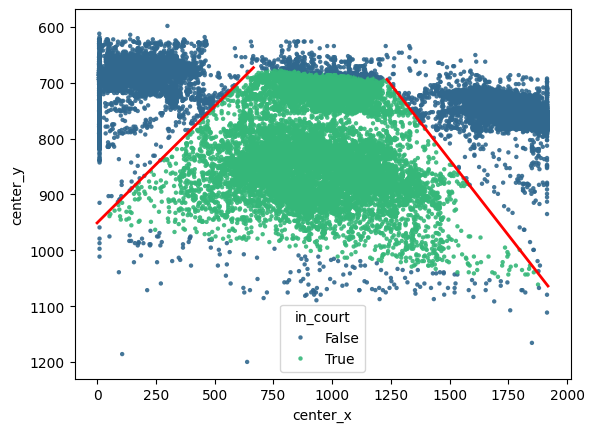

In [320]:
sns.scatterplot(data=df,x='center_x',y='center_y',hue="in_court",palette="viridis",linewidth=0,alpha=0.9,s=10)
x1, y1=upper_left
x2, y2=lower_left
plt.plot([x1, x2], [y1, y2], color='red', linewidth=2)
x1, y1=upper_right
x2, y2=lower_right
plt.plot([x1, x2], [y1, y2], color='red', linewidth=2)
plt.gca().invert_yaxis()


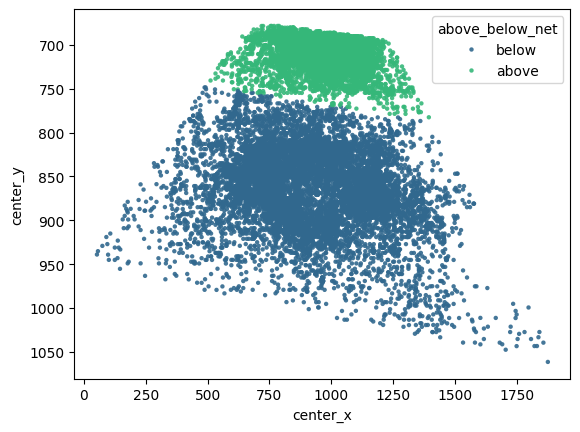

In [321]:
sns.scatterplot(data=df[df.in_court==True],x='center_x',y='center_y',hue="above_below_net",palette="viridis",linewidth=0,alpha=0.9,s=10)
plt.gca().invert_yaxis()


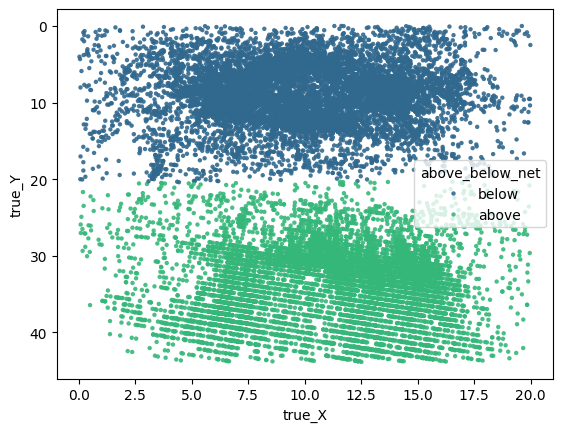

In [322]:
sns.scatterplot(data=df[df.in_court==True],x='true_X',y='true_Y',hue="above_below_net",palette="viridis",linewidth=0,alpha=0.9,s=10)
plt.gca().invert_yaxis()

In [336]:
# Example dataframe with true coordinates (truex, truey)
tmp = pd.DataFrame({
    'truex': [2, 10, 5, 15, 3, 8, 19],
    'truey': [5, 15, 10, 3, 18, 22, 7]
})

# Court dimensions
a = 22  # court length (feet)
b = 20  # court width (feet)

# Weights for the grid (3x3 grid with 0.3, 0.4, 0.3 proportions)
horizontal_splits = [0.3 * b, 0.7 * b]  # [left, middle, right]
vertical_splits = [0.3 * a, 0.7 * a]  # [bottom, middle, top]

# Function to assign grid cells based on true coordinates
def assign_grid_cell(x, y):
    # Determine horizontal position (left, middle, right)
    if x <= horizontal_splits[0]:  # Left section
        col = 3
    elif x <= horizontal_splits[1]:  # Middle section
        col = 2
    else:  # Right section
        col = 1

    # Determine vertical position (top, middle, bottom)
    if y <= vertical_splits[0]:  # Bottom section
        row = 3
    elif y <= vertical_splits[1]:  # Middle section
        row = 2
    else:  # Top section
        row = 1

    # Calculate the grid cell number based on row and column
    return (row - 1) * 3 + col

# Apply the function to the dataframe
tmp['grid_cell'] = tmp.apply(lambda row: assign_grid_cell(row['truex'], row['truey']), axis=1)


In [337]:
dfa = df[df.above_below_net=="below"]
dfa['grid_cell'] = dfa.apply(lambda row: assign_grid_cell(row['true_X'], row['true_Y']), axis=1)


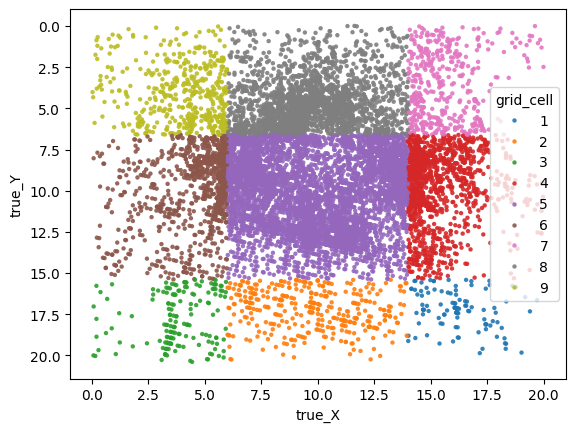

In [339]:
sns.scatterplot(data=dfa[dfa.in_court==True],x='true_X',y='true_Y',hue="grid_cell",palette="tab10",linewidth=0,alpha=0.9,s=10)
plt.gca().invert_yaxis()

In [350]:
dfb = df[df.above_below_net=="above"]
dfb['Y_inverse'] = dfb['true_Y']-22
# Define the center of rotation (a, b) and angle theta in degrees
a, b = 10, 11  # Example center point
theta_degrees = 180  # Rotate by 180 degrees clockwise
theta_radians = np.radians(theta_degrees)  # Convert degrees to radians

# Function to rotate a point (x, y) clockwise around the center (a, b) by theta degrees
def rotate_clockwise(x, y, a, b, theta):
    x_rotated = a + (x - a) * np.cos(theta) + (y - b) * np.sin(theta)
    y_rotated = b - (x - a) * np.sin(theta) + (y - b) * np.cos(theta)
    return x_rotated, y_rotated

# Apply the rotation to the dataframe
dfb[['x_rotated', 'y_rotated']] = dfb.apply(lambda row: rotate_clockwise(row['true_X'], row['Y_inverse'], a, b, theta_radians), axis=1, result_type='expand')


In [346]:
dfb

frame_number  l_foot_x  l_foot_y  r_foot_x  r_foot_y   center_x  \
1703         1415.0   365.613   666.367   301.422   658.512   333.5175   
1705         1415.0  1829.530   722.658     0.000     0.000  1829.5300   
1706         1415.0  1789.490   734.539     0.000     0.000  1789.4900   
1710         1420.0  1841.610   746.554     0.000     0.000  1841.6100   
1711         1420.0     0.000     0.000  1805.520   750.424  1805.5200   
...             ...       ...       ...       ...       ...        ...   
48509       38190.0     0.000     0.000  1913.830   786.761  1913.8300   
48510       38195.0   273.147   678.358   209.262   670.400   241.2045   
48511       38195.0  1773.290   746.458  1741.280   742.566  1757.2850   
48513       38195.0  1452.490   782.676  1432.600   778.599  1442.5450   
48514       38195.0  1913.880   786.720     0.000     0.000  1913.8800   

       center_y     true_X     true_Y above_below_net  in_court  grid_cell  \
1703   662.4395 -12.117699  43.195810           above     False          3   
1705   722.6580  38.175596  41.256355           above     False          1   
1706   734.5390  34.819718  36.364755           above     False          4   
1710   746.5540  34.782659  33.205302           above     False          4   
1711   750.4240  33.163212  31.681185           above     False          4   
...         ...        ...        ...             ...       ...        ...   
48509  786.7610  32.067021  24.095891           above     False          7   
48510  674.3790 -12.865568  36.714680           above     False          6   
48511  744.5120  32.432582  32.838188           above     False          4   
48513  780.6375  21.127911  21.506785           above     False          7   
48514  786.7200  32.072418  24.104532           above     False          7   

       x_rotated  y_rotated  
1703   32.117699 -21.195810  
1705  -18.175596 -19.256355  
1706  -14.819718 -14.364755  
1710  -14.782659 -11.205302  
1711  -13.163212  -9.681185  
...          ...        ...  
48509 -12.067021  -2.095891  
48510  32.865568 -14.714680  
48511 -12.432582 -10.838188  
48513  -1.127911   0.493215  
48514 -12.072418  -2.104532  

[28909 rows x 14 columns]

In [351]:
dfb['grid_cell'] = dfb.apply(lambda row: assign_grid_cell(row['x_rotated'], row['y_rotated']), axis=1)


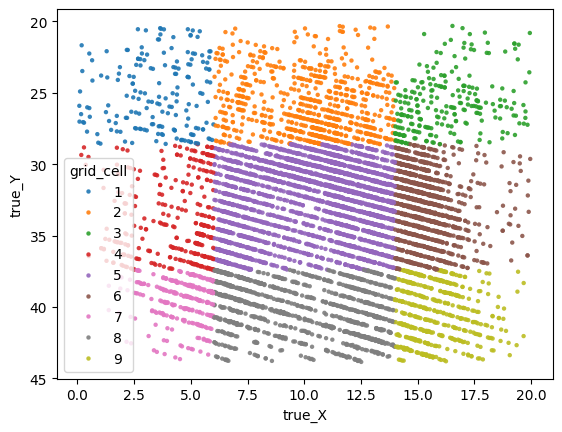

In [352]:
sns.scatterplot(data=dfb[dfb.in_court==True],x='true_X',y='true_Y',hue="grid_cell",palette="tab10",linewidth=0,alpha=0.9,s=10)
plt.gca().invert_yaxis()

In [353]:
df = pd.concat([dfa,dfb.drop(['Y_inverse','x_rotated', 'y_rotated'],axis=1)])

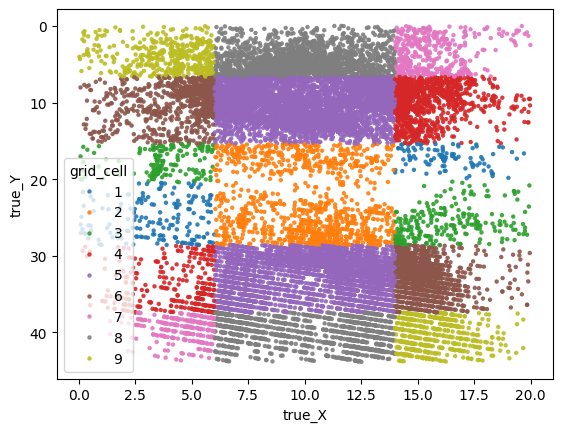

In [354]:
sns.scatterplot(data=df[df.in_court==True],x='true_X',y='true_Y',hue="grid_cell",palette = "tab10",linewidth=0,alpha=0.9,s=10)
plt.gca().invert_yaxis()

In [355]:
df

frame_number  l_foot_x  l_foot_y  r_foot_x  r_foot_y   center_x  \
1702         1415.0   758.681   879.009   762.671   883.111   760.6760   
1704         1415.0   975.305   834.821   987.256   826.782   981.2805   
1708         1420.0   790.631   878.889   782.513   882.888   786.5720   
1709         1420.0   975.329   822.872   991.192   822.708   983.2605   
1714         1425.0   786.734   886.904   786.596   878.902   786.6650   
...             ...       ...       ...       ...       ...        ...   
48509       38190.0     0.000     0.000  1913.830   786.761  1913.8300   
48510       38195.0   273.147   678.358   209.262   670.400   241.2045   
48511       38195.0  1773.290   746.458  1741.280   742.566  1757.2850   
48513       38195.0  1452.490   782.676  1432.600   778.599  1442.5450   
48514       38195.0  1913.880   786.720     0.000     0.000  1913.8800   

       center_y     true_X     true_Y above_below_net  in_court  grid_cell  
1702   881.0600   7.839957   6.255922           below      True          8  
1704   830.8015  10.999066  11.644705           below      True          5  
1708   880.8885   8.198268   6.365199           below      True          8  
1709   822.7900  11.042494  12.534980           below      True          5  
1714   882.9030   8.214367   6.218317           below      True          8  
...         ...        ...        ...             ...       ...        ...  
48509  786.7610  32.067021  24.095891           above     False          3  
48510  674.3790 -12.865568  36.714680           above     False          4  
48511  744.5120  32.432582  32.838188           above     False          6  
48513  780.6375  21.127911  21.506785           above     False          3  
48514  786.7200  32.072418  24.104532           above     False          3  

[43650 rows x 12 columns]

In [356]:
df.to_csv("IMG_9421_foot_positions.player_pos.csv",index=False)

# not sure if this is accurate, we have to test

In [ ]:
def round_to_nearest_5(n):
    return round(n / 5) * 5

# Example usage
number = 1829.5300
rounded_number = round_to_nearest_5(number)
print(rounded_number)

In [147]:
df['x'] = df.center_x.apply(round_to_nearest_5)
df['y'] = df.center_y.apply(round_to_nearest_5)

In [148]:
df2 = df.merge(df.groupby(['x','y']).size().reset_index(),left_on=["x","y"],right_on=["x","y"],how="left")

In [130]:
df2

frame_number  l_foot_x  l_foot_y  r_foot_x  r_foot_y   center_x  \
0            1415.0   758.681   879.009   762.671   883.111   760.6760   
1            1415.0   365.613   666.367   301.422   658.512   333.5175   
2            1415.0   975.305   834.821   987.256   826.782   981.2805   
3            1415.0  1829.530   722.658     0.000     0.000  1829.5300   
4            1415.0  1789.490   734.539     0.000     0.000  1789.4900   
...             ...       ...       ...       ...       ...        ...   
43645       38195.0   273.147   678.358   209.262   670.400   241.2045   
43646       38195.0  1773.290   746.458  1741.280   742.566  1757.2850   
43647       38195.0  1268.070   923.074  1259.980   931.106  1264.0250   
43648       38195.0  1452.490   782.676  1432.600   778.599  1442.5450   
43649       38195.0  1913.880   786.720     0.000     0.000  1913.8800   

       center_y     x    y   0  
0      881.0600   760  880   1  
1      662.4395   335  660   8  
2      830.8015   980  830   6  
3      722.6580  1830  725   3  
4      734.5390  1790  735   9  
...         ...   ...  ...  ..  
43645  674.3790   240  675  13  
43646  744.5120  1755  745  29  
43647  927.0900  1265  925   2  
43648  780.6375  1445  780  12  
43649  786.7200  1915  785  56  

[43650 rows x 10 columns]

# automatic clustering not working, the best way is to define the court lines

In [2]:
import cv2
cap = cv2.VideoCapture("IMG_9421.MOV")
for i in range(500):
    cap.read()
ret, frame = cap.read()
img = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)

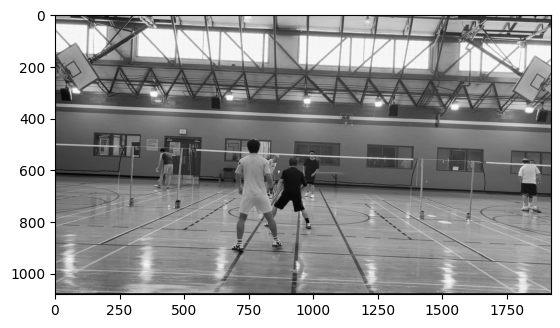

In [3]:
for i in range(1000):
    cap.read()
ret, frame = cap.read()
img = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)

plt.imshow(img, 'gray')

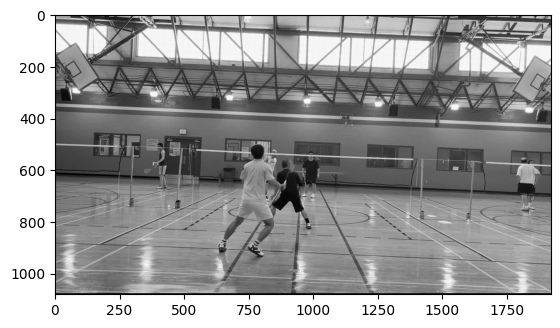

In [206]:
ret, frame = cap.read()
img = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)

plt.imshow(img, 'gray')

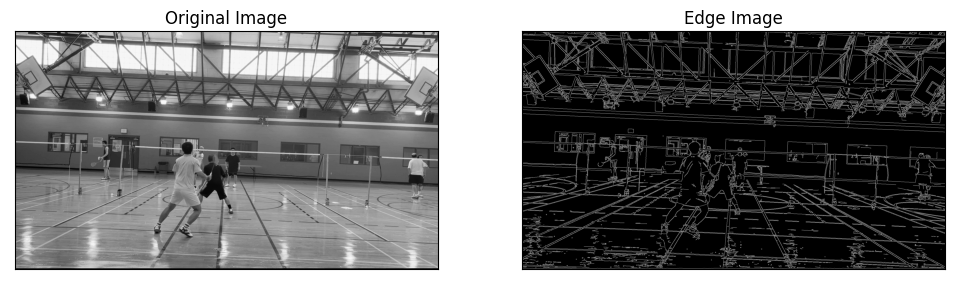

In [207]:
import numpy as np

# Visualizing edges

v = np.median(img)
sigma = 0.33 

#---- apply automatic Canny edge detection using the computed median----
lower = int(max(0, (1.0 - sigma) * v)) 
upper = int(min(255, (1.0 + sigma) * v)) 
edges = cv2.Canny(img, lower, upper, apertureSize=3) 

plt.figure(figsize=(12,8))
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

In [104]:
from copy import deepcopy as dp

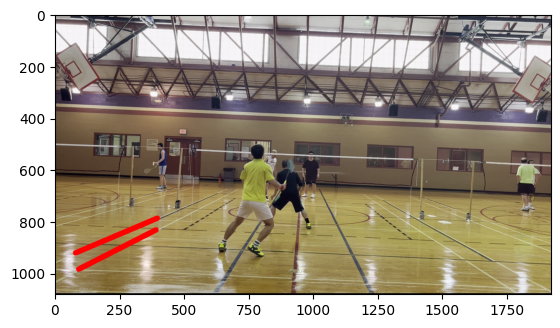

In [208]:
# Assuming your image height is 1080
image_height = 1080  # Or dynamically get the height using image.shape[0]

# Detect lines using Probabilistic Hough Line Transform
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 100, minLineLength=200, maxLineGap=10)
bottom_lines = []
# Only use lines from the bottom half of the image
frame2 = dp(frame)
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        
        # Filter to only use lines in the bottom half of the image
        if y1 > image_height / 2 and y2 > image_height / 2:
            if x1<100 and y1>900:
                bottom_lines.append(line)
                cv2.line(frame2, (x1, y1), (x2, y2), (0, 0, 255), 20)
plt.imshow(cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB))
# The rest of your display or saving logic goes here

In [118]:
polygon_points = np.array([(689, 596), (0, 913), (0, 1080), (1920, 1080), (1920, 958), (1263, 615)], np.int32)


[array([[ 50, 933, 664, 673]], dtype=int32),
 array([[ 90, 984, 360, 847]], dtype=int32),
 array([[  1, 955, 229, 858]], dtype=int32),
 array([[ 99, 980, 335, 860]], dtype=int32)]

Closest line to left_line: [0, 955, 689, 662], Distance: 38.57330831988233
Closest line to right_line: [1263, 712, 1920, 1075], Distance: 101.97317410247635


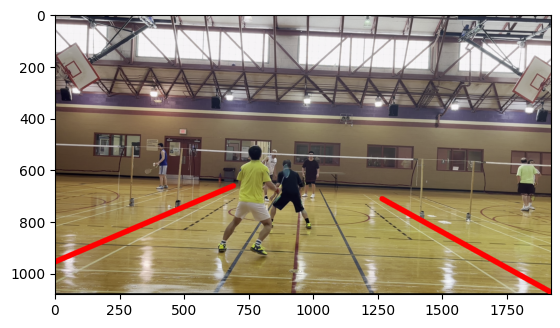

In [140]:
left_line = [0, 913, 689, 596]
right_line = [1263,596,1920,958]
# Function to calculate the slope of a line
def calculate_slope(x1, y1, x2, y2):
    if x2 - x1 == 0:  # Handle vertical lines (infinite slope)
        return float('inf')
    return (y2 - y1) / (x2 - x1)

# Function to calculate the perpendicular distance from a point (x0, y0) to a line defined by (x1, y1) to (x2, y2)
def point_to_line_distance(x0, y0, x1, y1, x2, y2):
    return abs((y2 - y1) * x0 - (x2 - x1) * y0 + x2 * y1 - y2 * x1) / np.sqrt((y2 - y1) ** 2 + (x2 - x1) ** 2)

# Function to find the line closest to a reference line, considering slope similarity
def find_closest_line(lines, reference_line, slope_tolerance=0.1):
    ref_x1, ref_y1, ref_x2, ref_y2 = reference_line
    ref_slope = calculate_slope(ref_x1, ref_y1, ref_x2, ref_y2)

    closest_line = None
    min_distance = float('inf')

    for line in lines:
        x1, y1, x2, y2 = line[0]

        # Calculate the slope of the current line
        slope = calculate_slope(x1, y1, x2, y2)

        # Check if the slope difference is within the tolerance
        if abs(slope - ref_slope) <= slope_tolerance:
            # Calculate the distance from each endpoint of the line to the reference line
            dist1 = point_to_line_distance(x1, y1, ref_x1, ref_y1, ref_x2, ref_y2)
            dist2 = point_to_line_distance(x2, y2, ref_x1, ref_y1, ref_x2, ref_y2)

            # Find the minimum distance between the two endpoints and the reference line
            distance = min(dist1, dist2)

            # Update the closest line if the distance is smaller
            if distance < min_distance:
                min_distance = distance
                closest_line = line

    return closest_line, min_distance
#he closest line to the left reference line
# Function to calculate the slope (m) and intercept (b) of a line given two points
def calculate_slope_intercept(x1, y1, x2, y2):
    if x2 - x1 == 0:  # Handle vertical lines
        return float('inf'), float('inf')
    slope = (y2 - y1) / (x2 - x1)
    intercept = y1 - slope * x1
    return slope, intercept
# Function to interpolate the detected line to match the x coordinates of a reference line
def interpolate_line(detected_line, reference_line):
    # Get slope and intercept for the detected line
    x1, y1, x2, y2 = detected_line[0]
    slope, intercept = calculate_slope_intercept(x1, y1, x2, y2)

    # Get the x coordinates from the reference line
    ref_x1, ref_y1, ref_x2, ref_y2 = reference_line

    # Interpolate y values for the detected line at the reference x1 and x2
    if slope != float('inf'):  # For non-vertical lines
        interp_y1 = slope * ref_x1 + intercept
        interp_y2 = slope * ref_x2 + intercept
    else:
        # For vertical lines, y values remain the same
        interp_y1, interp_y2 = y1, y2

    return [ref_x1, int(interp_y1), ref_x2, int(interp_y2)]
    
closest_left_line, left_distance = find_closest_line(lines, left_line)
closest_left_line = interpolate_line(closest_left_line, left_line)
print(f"Closest line to left_line: {closest_left_line}, Distance: {left_distance}")

# Find the closest line to the right reference line
closest_right_line, right_distance = find_closest_line(lines, right_line)
closest_right_line = interpolate_line(closest_right_line, right_line)

print(f"Closest line to right_line: {closest_right_line}, Distance: {right_distance}")
frame2 = dp(frame)

cv2.line(frame2, (closest_left_line[0], closest_left_line[1]), (closest_left_line[2], closest_left_line[3]), (0, 0, 255), 20)
cv2.line(frame2, (closest_right_line[0], closest_right_line[1]), (closest_right_line[2], closest_right_line[3]), (0, 0, 255), 20)
plt.imshow(cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB))

In [236]:
closest_right_line

[1263, 712, 1920, 1075]

In [237]:
closest_left_line

[0, 955, 689, 662]

In [181]:
import pandas as pd

# Function to calculate the slope (m) and intercept (b) of a line given two points
def calculate_slope_intercept(x1, y1, x2, y2):
    if x2 - x1 == 0:  # Handle vertical lines
        return float('inf'), float('inf')
    slope = (y2 - y1) / (x2 - x1)
    intercept = y1 - slope * x1
    return slope, intercept

# Function to check if a point (x, y) lies between two lines
def is_point_between_lines(x, y, left_slope, left_intercept, right_slope, right_intercept):
    # Calculate the y value on the left and right line for the given x
    y_left = left_slope * x + left_intercept if left_slope != float('inf') else float('inf')
    y_right = right_slope * x + right_intercept if right_slope != float('inf') else float('inf')
    psuedo=0
    y=y*1.05
    # Check if the y coordinate of the point is between y_left and y_right
    return y_left+psuedo >= y >= y_right-psuedo or y_left-psuedo <= y <= y_right+psuedo


# Calculate slopes and intercepts for the left and right lines
left_slope, left_intercept = calculate_slope_intercept(*closest_left_line)
right_slope, right_intercept = calculate_slope_intercept(*closest_right_line)

# Add a new column to the DataFrame indicating if the point is between the two lines
df2['between_lines'] = df2.apply(lambda row: is_point_between_lines(row['x'], row['y'], left_slope, left_intercept, right_slope, right_intercept), axis=1)



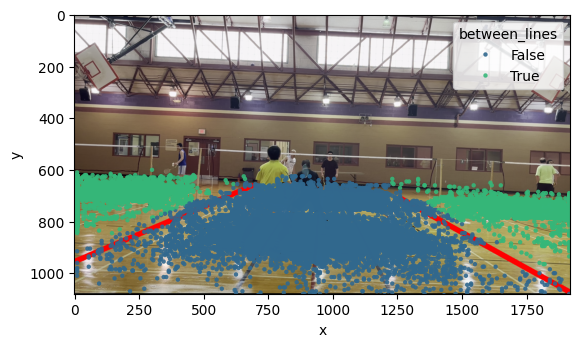

In [182]:
sns.scatterplot(data=df2,x='x',y='y',hue="between_lines",palette="viridis",linewidth=0,alpha=0.9,s=10)
plt.gca().invert_yaxis()
plt.imshow(cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB))

In [196]:
df3 = df2[df2[0]>5]
df3 = df3[df3.between_lines==False]

In [197]:
import pandas as pd
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters=2, random_state=42)
df3['cluster'] = kmeans.fit_predict(df3[['y']])

# Get cluster centers
cluster_centers = kmeans.cluster_centers_

# Add cluster center coordinates to each row

df3['center_y'] = df3['cluster'].apply(lambda cluster: cluster_centers[cluster][0])
# Determine the cluster name based on the center's Y value
# The cluster with the higher Y center value gets name 'A', the other 'B'
if cluster_centers[0] > cluster_centers[1]:
    cluster_names = {0: 'A', 1: 'B'}
else:
    cluster_names = {0: 'B', 1: 'A'}

df3['cluster_name'] = df3['cluster'].map(cluster_names)

# Display the DataFrame
df3.head()


frame_number  l_foot_x  l_foot_y  r_foot_x  r_foot_y  center_x  \
2         1415.0   975.305   834.821   987.256   826.782  981.2805   
5         1420.0   790.631   878.889   782.513   882.888  786.5720   
6         1420.0   975.329   822.872   991.192   822.708  983.2605   
10        1425.0   786.734   886.904   786.596   878.902  786.6650   
11        1425.0   979.278   830.808  1003.220   822.762  991.2490   

      center_y    x    y   0  between_lines  cluster cluster_name  
2   857.625665  980  830   6          False        1            A  
5   857.625665  785  880   9          False        1            A  
6   857.625665  985  825  21          False        1            A  
10  857.625665  785  885   8          False        1            A  
11  857.625665  990  825  11          False        1            A

In [198]:
df3['center_x']  = df3.cluster_name.map(df3.groupby("cluster_name").center_x.mean())

In [199]:
df3

frame_number  l_foot_x  l_foot_y  r_foot_x  r_foot_y    center_x  \
2            1415.0   975.305   834.821   987.256   826.782  924.984975   
5            1420.0   790.631   878.889   782.513   882.888  924.984975   
6            1420.0   975.329   822.872   991.192   822.708  924.984975   
10           1425.0   786.734   886.904   786.596   878.902  924.984975   
11           1425.0   979.278   830.808  1003.220   822.762  924.984975   
...             ...       ...       ...       ...       ...         ...   
43616       38165.0  1452.450   782.672  1436.440   778.648  990.389553   
43622       38170.0  1452.540   782.599  1436.540   778.562  990.389553   
43638       38185.0  1452.490   782.687  1432.540   778.531  990.389553   
43643       38190.0  1448.560   782.606  1436.530   778.576  990.389553   
43648       38195.0  1452.490   782.676  1432.600   778.599  990.389553   

         center_y     x    y   0  between_lines  cluster cluster_name  
2      857.625665   980  830   6          False        1            A  
5      857.625665   785  880   9          False        1            A  
6      857.625665   985  825  21          False        1            A  
10     857.625665   785  885   8          False        1            A  
11     857.625665   990  825  11          False        1            A  
...           ...   ...  ...  ..            ...      ...          ...  
43616  711.716896  1445  780  12          False        0            B  
43622  711.716896  1445  780  12          False        0            B  
43638  711.716896  1445  780  12          False        0            B  
43643  711.716896  1445  780  12          False        0            B  
43648  711.716896  1445  780  12          False        0            B  

[13162 rows x 13 columns]

<AxesSubplot:xlabel='x', ylabel='y'>

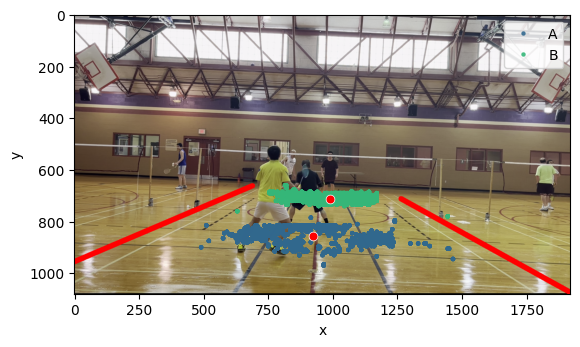

In [200]:
sns.scatterplot(data=df3,x='x',y='y',hue="cluster_name",palette="viridis",linewidth=0,alpha=0.9,s=10)
plt.gca().invert_yaxis()
plt.imshow(cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB))
sns.scatterplot(data=df3.drop_duplicates("center_y"),x='center_x',y='center_y',color="red",s=40)


In [259]:
# Define image center (y-coordinate)
center_y = df3[df3.cluster_name=="B"].center_y.tolist()[0]
y_max = df3[df3.cluster_name=="A"].center_y.tolist()[0]
closest_h_line = None
min_distance_to_center = float('inf')
slope_t=0.1
# Iterate over each line
for line in lines:
    x1, y1, x2, y2 = line[0]
    if x2 < (closest_left_line[0]+closest_left_line[2])/2:
        continue
    if x1 > (closest_right_line[0]+closest_right_line[2])/2:
        continue
    if (y1+y2)/2<center_y:
        continue     
    if (y1+y2)/2>y_max:
        continue   
    # Check if the line is horizontal (or nearly horizontal)
    slope, intercept = calculate_slope_intercept(x1, y1, x2, y2)
    if abs(slope) < slope_t:  # Horizontal line check with a small tolerance
        # Calculate the midpoint's Y-coordinate
        mid_y = (y1 + y2) / 2
        print (slope)
        # Calculate the absolute distance from the image center
        distance_to_center = abs(mid_y - center_y)
        
        # Find the line closest to the center
        if distance_to_center < min_distance_to_center:
            min_distance_to_center = distance_to_center
            closest_h_line = [x1, y1, x2, y2]
def interpolate_line_x(detected_line, ref_x1,ref_x2):
    # Get slope and intercept for the detected line
    x1, y1, x2, y2 = detected_line
    slope, intercept = calculate_slope_intercept(x1, y1, x2, y2)

    # Interpolate y values for the detected line at the reference x1 and x2
    if slope != float('inf'):  # For non-vertical lines
        interp_y1 = slope * ref_x1 + intercept
        interp_y2 = slope * ref_x2 + intercept
    else:
        # For vertical lines, y values remain the same
        interp_y1, interp_y2 = y1, y2

    return [ref_x1, int(interp_y1), ref_x2, int(interp_y2)]
closest_h_line = interpolate_line_x(closest_h_line, 0,1920)


0.05211726384364821
0.049707602339181284
0.04912280701754386


In [261]:
closest_h_line

[0, 715, 1920, 815]

In [220]:
x1

423

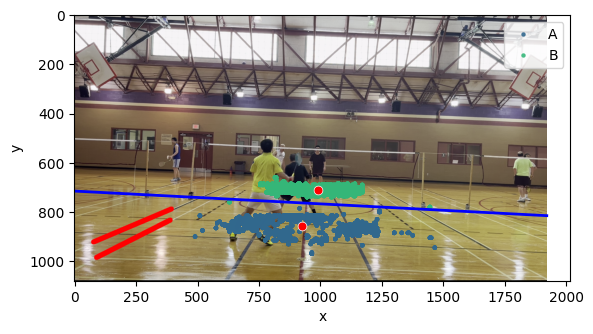

In [260]:
sns.scatterplot(data=df3,x='x',y='y',hue="cluster_name",palette="viridis",linewidth=0,alpha=0.9,s=10)
plt.gca().invert_yaxis()
plt.imshow(cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB))
sns.scatterplot(data=df3.drop_duplicates("center_y"),x='center_x',y='center_y',color="red",s=40)
x1, y1, x2, y2=closest_h_line
plt.plot([x1, x2], [y1, y2], color='blue', linewidth=2)

In [267]:
slope, intercept = calculate_slope_intercept(*closest_h_line)
df2['Player_position'] = df2.apply(lambda row: 'above' if row['center_y'] > (slope * row['center_x'] + intercept) else 'below', axis=1)


In [272]:
df2 = df2[df2.between_lines==False]

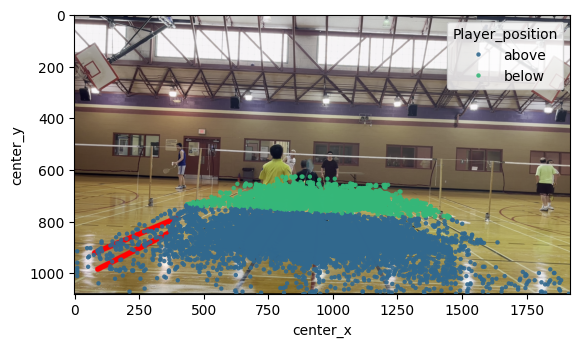

In [273]:
sns.scatterplot(data=df2,x='center_x',y='center_y',hue="Player_position",palette="viridis",linewidth=0,alpha=0.9,s=10)
plt.gca().invert_yaxis()
plt.imshow(cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB))
# sns.scatterplot(data=df3.drop_duplicates("center_y"),x='center_x',y='center_y',color="red",s=40)
# x1, y1, x2, y2=closest_h_line
# plt.plot([x1, x2], [y1, y2], color='blue', linewidth=2)

In [276]:
closest_left_line

[0, 955, 689, 662]

In [277]:
closest_right_line

[1263, 712, 1920, 1075]

In [274]:
closest_left_line
closest_left_line
closest_h_line
import pandas as pd
import numpy as np

# Define left, right, and "horizontal" lines with 4 values each
left_line = closest_left_line   # (a, b) -> (c, d)
right_line = closest_right_line  # (i, j) -> (k, l)
horizontal_line = closest_h_line  # (e, f) -> (g, h)


# Function to calculate distance from a point to a line segment
def point_line_segment_distance(x, y, x1, y1, x2, y2):
    # Line segment vector
    dx, dy = x2 - x1, y2 - y1
    # Handle case when the line is a point
    if dx == 0 and dy == 0:
        return np.hypot(x - x1, y - y1)
    # Parametrize the point on the segment
    t = max(0, min(1, ((x - x1) * dx + (y - y1) * dy) / (dx * dx + dy * dy)))
    # Find the projection of the point onto the segment
    proj_x = x1 + t * dx
    proj_y = y1 + t * dy
    return np.hypot(x - proj_x, y - proj_y)

# Add distances to left line, right line, and horizontal line
df2['dist_to_left'] = df2.apply(lambda row: point_line_segment_distance(row['center_x'], row['center_y'], left_line[0], left_line[1], left_line[2], left_line[3]), axis=1)
df2['dist_to_right'] = df2.apply(lambda row: point_line_segment_distance(row['center_x'], row['center_y'], right_line[0], right_line[1], right_line[2], right_line[3]), axis=1)
df2['dist_to_horizontal'] = df2.apply(lambda row: point_line_segment_distance(row['center_x'], row['center_y'], horizontal_line[0], horizontal_line[1], horizontal_line[2], horizontal_line[3]), axis=1)



In [275]:
df2

frame_number  l_foot_x  l_foot_y  r_foot_x  r_foot_y   center_x  \
0            1415.0   758.681   879.009   762.671   883.111   760.6760   
2            1415.0   975.305   834.821   987.256   826.782   981.2805   
5            1420.0   790.631   878.889   782.513   882.888   786.5720   
6            1420.0   975.329   822.872   991.192   822.708   983.2605   
10           1425.0   786.734   886.904   786.596   878.902   786.6650   
...             ...       ...       ...       ...       ...        ...   
43638       38185.0  1452.490   782.687  1432.540   778.531  1442.5150   
43642       38190.0  1268.180   915.145  1263.840   927.049  1266.0100   
43643       38190.0  1448.560   782.606  1436.530   778.576  1442.5450   
43647       38195.0  1268.070   923.074  1259.980   931.106  1264.0250   
43648       38195.0  1452.490   782.676  1432.600   778.599  1442.5450   

       center_y     x    y   0  between_lines Player_position  dist_to_left  \
0      881.0600   760  880   1          False           above    229.638841   
2      830.8015   980  830   6          False           above    337.523091   
5      880.8885   785  880   9          False           above    239.650726   
6      822.7900   985  825  21          False           above    335.324717   
10     882.9030   785  885   8          False           above    241.529683   
...         ...   ...  ...  ..            ...             ...           ...   
43638  780.6090  1445  780  12          False           below    762.792862   
43642  921.0970  1265  920   2          False           above    632.512289   
43643  780.5910  1445  780  12          False           below    762.819698   
43647  927.0900  1265  925   2          False           above    633.187538   
43648  780.6375  1445  780  12          False           below    762.826929   

       dist_to_right  dist_to_horizontal  
0         530.010080          126.270309  
2         305.744457           64.605573  
5         505.476967          124.752117  
6         300.879730           56.501932  
10        506.066070          126.759053  
...              ...                 ...  
43638      26.761947            9.509101  
43642     181.564036          139.969262  
43643      26.792210            9.528637  
43647     187.769582          146.057396  
43648      26.751510            9.482200  

[23823 rows x 15 columns]

In [ ]:
# Function to calculate intersection of a horizontal line (y=constant) with a line segment
def intersection_with_line(y_value, x1, y1, x2, y2):
    # If the line is vertical, return the x-value directly
    if x1 == x2:
        return x1
    # Calculate the x-value at the given y_value (linear interpolation)
    if y1 != y2:
        x_intersection = x1 + (y_value - y1) * (x2 - x1) / (y2 - y1)
        return x_intersection
    else:
        return None  # No intersection if the line is horizontal itself

# For each point, calculate intersections of a new line (horizontal at y) with left and right lines
intersections = []
for index, row in df.iterrows():
    y_value = row['y']
    left_x = intersection_with_line(y_value, left_line[0], left_line[1], left_line[2], left_line[3])
    right_x = intersection_with_line(y_value, right_line[0], right_line[1], right_line[2], right_line[3])
    intersections.append([left_x, y_value, right_x, y_value])

# Create a new dataframe for intersections
intersection_df = pd.DataFrame(intersections, columns=['left_x', 'left_y', 'right_x', 'right_y'])



# AIM:
# 1. Define 1-9 player's positions
# 2. extract all a particular hitting 
# 3. trim and rescale video to put ball and one player in the middle

# automatically find clusters, define center, and find two clusters closer to the image center

In [280]:
df2['x_scale'] = df2.x/df2.x.max()
df2['y_scale'] = df2.y/df2.y.max()

In [ ]:
df3 = clean_foot_pos(df2[df2[0]>20],a,b)
sns.scatterplot(data=df3,x='x',y='y',hue="Cluster",palette="viridis",linewidth=0)
plt.gca().invert_yaxis()

2 0.6263689615822816
3 0.7676789395771272
4 0.6442573920520324
5 0.6924465483272022


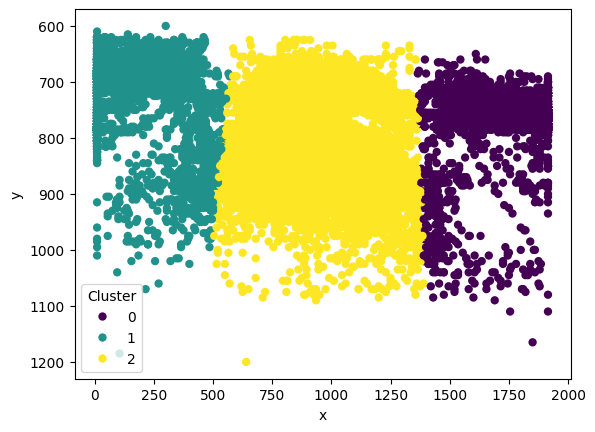

In [296]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from tslearn.clustering import KernelKMeans
def calculate_cluster_centers(X, labels):
    """
    Manually calculate the 'centers' of each cluster by taking the mean of points in each cluster.
    """
    unique_labels = np.unique(labels)
    cluster_centers = []
    
    for label in unique_labels:
        if label != -1:  # Skip noise points labeled as -1
            cluster_points = X[labels == label]
            cluster_center = np.mean(cluster_points, axis=0)
            cluster_centers.append(cluster_center)
    
    return np.array(cluster_centers)
import sklearn
# def find_best_clusters(df, possible_clusters=[2, 3, 4, 5, 6]):
def find_best_clusters(df,possible_clusters=[2, 3,4, 5]):
    """
    Find the best number of clusters based on silhouette score.
    """
    best_n_clusters = None
    best_score = -1
    best_kmeans = None
    X = df[['x_scale', 'y_scale']].values
    for n_clusters in possible_clusters:
        kmeans = KMeans(n_clusters)
        labels = kmeans.fit_predict(X)
        score = silhouette_score(X, labels)
        print (n_clusters,score)
        if score > best_score:
            best_n_clusters = n_clusters
            best_score = score
            best_kmeans = kmeans
            best_labels = labels
    best_kmeans.cluster_centers_ =    calculate_cluster_centers(X, best_labels)         
    best_kmeans.labels_ = best_labels       
    return best_kmeans, best_n_clusters

def define_cluster_names(cluster_centers):
    """
    Define cluster names based on the Y-axis value of the cluster centers.
    """
    cluster_names = {}
    sorted_centers = sorted(cluster_centers, key=lambda x: x[1])  # Sort by Y value
    
    for i, center in enumerate(sorted_centers):
        cluster_names[tuple(center)] = f"Cluster_{i+1}"
    
    return cluster_names

def find_closest_clusters(kmeans, cluster_centers, a, b, num_clusters=2):
    """
    Find the two clusters closest to point (a, b).
    """
    distances = []
    
    for center in cluster_centers:
        distance = np.sqrt((center[0] - a)**2 + (center[1] - b)**2)
        distances.append((distance, center))
    
    distances = sorted(distances, key=lambda x: x[0])  # Sort by distance
    closest_clusters = distances[:num_clusters]
    
    return closest_clusters

def add_cluster_info_to_dataframe(df, kmeans, cluster_names):
    """
    Add cluster labels and cluster center information to the dataframe.
    """
    X = df[['x_scale', 'y_scale']].values
    df['Cluster'] = kmeans.predict(X)
    
    # Map the cluster names based on the center
    cluster_centers = kmeans.cluster_centers_
    center_dict = {i: cluster_names[tuple(center)] for i, center in enumerate(cluster_centers)}
    df['Cluster_Name'] = df['Cluster'].map(center_dict)
    
    # Add cluster center coordinates to each row
    df['Cluster_Center_X'] = df['Cluster'].apply(lambda label: cluster_centers[label][0])
    df['Cluster_Center_Y'] = df['Cluster'].apply(lambda label: cluster_centers[label][1])
    
    return df

# Example usage
def clean_foot_pos(df,a,b):

    # Find the best KMeans model and number of clusters
    kmeans, best_n_clusters = find_best_clusters(df[df[0]>5])

    # Get cluster centers
    cluster_centers = kmeans.cluster_centers_

    # Define cluster names based on Y-axis value of the cluster centers
    cluster_names = define_cluster_names(cluster_centers)

    # Add cluster information (name, center coordinates) to the dataframe
    df_with_clusters = add_cluster_info_to_dataframe(df, kmeans, cluster_names)

    return df_with_clusters
a=1920
b=1080
df3 = clean_foot_pos(df2,a,b)
sns.scatterplot(data=df3,x='x',y='y',hue="Cluster",palette="viridis",linewidth=0)
plt.gca().invert_yaxis()


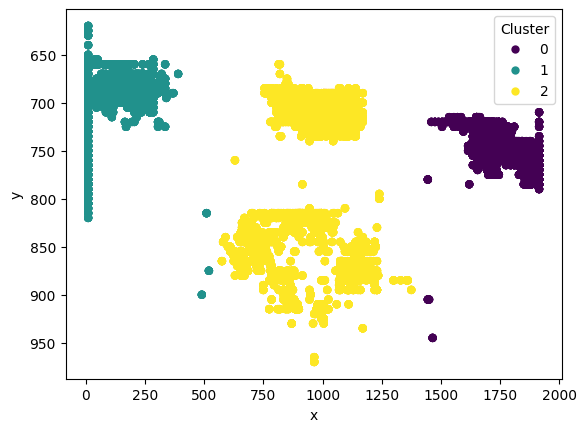

In [298]:
sns.scatterplot(data=df3[df3[0]>5],x='x',y='y',hue="Cluster",palette="viridis",linewidth=0)
plt.gca().invert_yaxis()

In [288]:
df3

frame_number  l_foot_x  l_foot_y  r_foot_x  r_foot_y   center_x  \
6            1420.0   975.329   822.872   991.192   822.708   983.2605   
7            1420.0  1841.610   746.554     0.000     0.000  1841.6100   
8            1420.0     0.000     0.000  1805.520   750.424  1805.5200   
12           1425.0  1837.570   746.588  1805.520   750.410  1821.5450   
16           1430.0   979.047   830.847   995.300   818.855   987.1735   
...             ...       ...       ...       ...       ...        ...   
43636       38185.0  1773.290   742.580  1741.280   746.472  1757.2850   
43641       38190.0  1773.330   746.443  1741.360   742.562  1757.3450   
43644       38190.0     0.000     0.000  1913.830   786.761  1913.8300   
43646       38195.0  1773.290   746.458  1741.280   742.566  1757.2850   
43649       38195.0  1913.880   786.720     0.000     0.000  1913.8800   

       center_y     x    y   0   x_scale   y_scale  Cluster Cluster_Name  \
6      822.7900   985  825  21  0.514360  0.687500        2    Cluster_2   
7      746.5540  1840  745  34  0.960836  0.620833        0    Cluster_3   
8      750.4240  1805  750  23  0.942559  0.625000        0    Cluster_3   
12     748.4990  1820  750  44  0.950392  0.625000        0    Cluster_3   
16     824.8510   985  825  21  0.514360  0.687500        2    Cluster_2   
...         ...   ...  ...  ..       ...       ...      ...          ...   
43636  744.5260  1755  745  29  0.916449  0.620833        0    Cluster_3   
43641  744.5025  1755  745  29  0.916449  0.620833        0    Cluster_3   
43644  786.7610  1915  785  56  1.000000  0.654167        0    Cluster_3   
43646  744.5120  1755  745  29  0.916449  0.620833        0    Cluster_3   
43649  786.7200  1915  785  56  1.000000  0.654167        0    Cluster_3   

       Cluster_Center_X  Cluster_Center_Y  
6            986.244571        751.620521  
7           1801.491779        753.237576  
8           1801.491779        753.237576  
12          1801.491779        753.237576  
16           986.244571        751.620521  
...                 ...               ...  
43636       1801.491779        753.237576  
43641       1801.491779        753.237576  
43644       1801.491779        753.237576  
43646       1801.491779        753.237576  
43649       1801.491779        753.237576  

[12991 rows x 16 columns]

In [193]:
192.0	648.0
1	1728.0	648.0
2	960.0	648.0
3	960.0	972.0

(9733, 10)

In [234]:
df3["y"] = df3["y"]/2

In [247]:
init_centers

array([[ 192.,   54.],
       [1728.,   54.],
       [ 960.,   54.],
       [ 960.,  486.]])

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import community as community_louvain
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt

def louvain_clustering(X, resolution=1.0):
    """
    Perform Louvain clustering on the input data X with a resolution parameter.
    """
    # Create a k-nearest neighbors graph
    knn_graph = kneighbors_graph(X, n_neighbors=100, include_self=False)

    # Convert the sparse matrix to a NetworkX graph
    G = nx.from_scipy_sparse_array(knn_graph)  # Use this for newer versions of networkx

    # Perform Louvain clustering with the specified resolution
    partition = community_louvain.best_partition(G, resolution=resolution)

    # Extract labels
    labels = np.array([partition[i] for i in range(len(X))])

    return labels

def calculate_cluster_centers(X, labels):
    """
    Manually calculate the 'centers' of each cluster by taking the mean of points in each cluster.
    """
    unique_labels = np.unique(labels)
    cluster_centers = []
    
    for label in unique_labels:
        if label != -1:  # Skip noise points labeled as -1
            cluster_points = X[labels == label]
            cluster_center = np.mean(cluster_points, axis=0)
            cluster_centers.append(cluster_center)
    
    return np.array(cluster_centers)

def find_best_louvain_clusters(df, a, b, resolutions=[100]):
    """
    Find the best clustering using the Louvain algorithm by searching over different resolutions.
    """
    X = df[['x', 'y']].values
    best_resolution = None
    best_score = -1
    best_labels = None
    best_centers = None
    
    # Iterate through each resolution
    for resolution in resolutions:
        # Perform Louvain clustering with the current resolution
        labels = louvain_clustering(X, resolution=resolution)
        
        # Calculate cluster centers
        cluster_centers = calculate_cluster_centers(X, labels)
        
        # Calculate silhouette score
        if len(np.unique(labels)) > 1:  # Ensure there is more than one cluster
            score = silhouette_score(X, labels)
            print(f"Resolution: {resolution}, Silhouette Score: {score}")

            if score > best_score:
                best_score = score
                best_labels = labels
                best_centers = cluster_centers
                best_resolution = resolution
    
    print(f"Best Resolution: {best_resolution}, Best Silhouette Score: {best_score}")
    
    return best_labels, best_centers, best_score

def define_cluster_names(cluster_centers):
    """
    Define cluster names based on the Y-axis value of the cluster centers.
    """
    cluster_names = {}
    sorted_centers = sorted(cluster_centers, key=lambda x: x[1])  # Sort by Y value
    
    for i, center in enumerate(sorted_centers):
        cluster_names[tuple(center)] = f"Cluster_{i+1}"
    
    return cluster_names

def find_closest_clusters(cluster_centers, a, b, num_clusters=2):
    """
    Find the two clusters closest to point (a, b).
    """
    distances = []
    
    for center in cluster_centers:
        distance = np.sqrt((center[0] - a)**2 + (center[1] - b)**2)
        distances.append((distance, center))
    
    distances = sorted(distances, key=lambda x: x[0])  # Sort by distance
    closest_clusters = distances[:num_clusters]
    
    return closest_clusters

def add_cluster_info_to_dataframe(df, labels, cluster_centers, cluster_names):
    """
    Add cluster labels and cluster center information to the dataframe.
    """
    df['Cluster'] = labels
    
    # Map the cluster names based on the center
    center_dict = {i: cluster_names[tuple(center)] for i, center in enumerate(cluster_centers)}
    df['Cluster_Name'] = df['Cluster'].map(lambda label: center_dict[label])
    
    # Add cluster center coordinates to each row
    df['Cluster_Center_X'] = df['Cluster'].apply(lambda label: cluster_centers[label][0])
    df['Cluster_Center_Y'] = df['Cluster'].apply(lambda label: cluster_centers[label][1])
    
    return df

# Example usage
def clean_foot_pos(df, a, b):
    # Find the best Louvain clustering model by searching different resolutions
    labels, cluster_centers, score = find_best_louvain_clusters(df, a, b)

    print(f"Cluster Centers: \n{cluster_centers}")

    # Define cluster names based on Y-axis value of the cluster centers
    cluster_names = define_cluster_names(cluster_centers)
    print(f"Cluster Names: {cluster_names}")

    # Add cluster information (name, center coordinates) to the dataframe
    df_with_clusters = add_cluster_info_to_dataframe(df, labels, cluster_centers, cluster_names)

    # Find the two closest clusters to the point (a, b)
    closest_clusters = find_closest_clusters(cluster_centers, a / 2, b / 2)
    print(f"Two closest clusters to ({a / 2}, {b / 2}):")
    
    for dist, center in closest_clusters:
        print(f"Distance: {dist}, Center: {center}, Name: {cluster_names[tuple(center)]}")

    return df_with_clusters

a = 1920
b = 1080

df3 = clean_foot_pos(df2[df2[0] > 10], a, b)

# Plotting the clusters
sns.scatterplot(data=df3, x='x', y='y', hue="Cluster", palette="viridis", linewidth=0)
plt.gca().invert_yaxis()
plt.show()
